# Comparing Single Value Read Times with Chunking Across Lat/Lon

This notebook compares reading times of Zarr and netCDF-4 data formats. The data used in this example is publicly avaliable from Unidata [example files](https://www.unidata.ucar.edu/software/netcdf/examples/files.html). The file is from the Community Climate System Model (CCSM) with one time step of precipitation flux, air temperature, and eastward wind. The data was converted from netCDF-3 to Zarr using [this repository](https://github.com/jonahjoughin/netcdf-to-zarr). 

The following chunk sizes applied to lat/lon were compared in this example:
* 128 x 256 (original)
* 64 x 64
* 16 x 16
* 4 x 4

Run times are recorded in seconds using `timeit` with the average taken of 100 excecutions.

## Chunking netCDF with nccopy utility

The netCDF-4 files were created from the original example file using Unidata's [nccopy utility](https://www.unidata.ucar.edu/software/netcdf/workshops/2011/utilities/Nccopy.html). Chunking dimensions were specified with the `-c chunkspec` option.

## Chunking Zarr directory store with Rechunker

The following code is an example of rechunking the Zarr directory store by lat/lon.

In [2]:
import zarr
from rechunker import rechunk
source = zarr.open('Data/ccsm3_store.zarr')
intermediate = "Data/intermediate.zarr"
target_store = "Data/ccsm3_store_64C.zarr"
max_mem = '3MB'

target_chunks = {
    'area': {'time': 1, 'lat': 64, 'lon': 64},
    'lat': { 'lat': 64},
    'lat_bnds': {'lat': 64, 'bnds': 2},
    'lon': {'lon': 64},
    'lon_bnds': {'lon': 64, 'bnds': 2},
    'msk_rgn': {'lat': 64, 'lon': 64},
    'plev': {'plev': 17},
    'pr': {'time': 1, 'lat': 64, 'lon': 64},
    'tas': {'time': 1, 'lat': 64, 'lon': 64},
    'time': {'time': 1},
    'time_bnds': {'time': 1, 'bnds': 2},
    'ua': {'time': 1,'plev' : 17, 'lat': 64, 'lon': 64},
}

!rm -rf air_rechunked.zarr air_rechunked-tmp.zarr
rechunked = rechunk(source, target_chunks, max_mem, target_store, temp_store=intermediate)
rechunked

<Rechunked>
* Source      : <zarr.hierarchy.Group '/'>

* Intermediate: <zarr.hierarchy.Group '/'>

* Target      : <zarr.hierarchy.Group '/'>

In [37]:
rechunked.execute()

_copy_chunk((slice(0, 1, None),))
_copy_chunk((slice(0, 1, None),))
_copy_chunk((slice(0, 128, None), slice(0, 2, None)))
_copy_chunk((slice(0, 1, None), slice(0, 128, None), slice(0, 256, None)))
_copy_chunk((slice(0, 256, None), slice(0, 2, None)))
_copy_chunk((slice(0, 256, None),))
_copy_chunk((slice(0, 1, None), slice(0, 17, None), slice(0, 128, None), slice(0, 256, None)))
_copy_chunk((slice(0, 1, None), slice(0, 128, None), slice(0, 256, None)))
_copy_chunk((slice(0, 128, None), slice(0, 256, None)))
_copy_chunk((slice(0, 128, None), slice(0, 256, None)))
_copy_chunk((slice(0, 17, None),))
_copy_chunk((slice(0, 128, None),))
_copy_chunk((slice(0, 1, None), slice(0, 2, None)))


<zarr.hierarchy.Group '/'>

## Reading netCDF-4

### Chunksize 128x256 (one chunk per array)

In [4]:
import timeit 
  
# import before timing begins 
imports = "import netCDF4 as nc"
  
# reading code to be timed
nc4_110_single_values = ''' 

# netCDF-4 with zlib compression 
dataset = nc.Dataset('Data/ccsm3_netcdf-4.nc')

# reading single values
tas = dataset.variables['tas'][0][0][0] # air temperature
plev = dataset.variables['plev'][0] # air pressure
pr = dataset.variables['pr'][0][0][0] # precipitation flux
ua = dataset.variables['ua'][0][0][0][0] # eastward wind with 17 levels of plev
lons = dataset.variables['lon'][0]
lat = dataset.variables['lat'][0]

dataset.close() 
'''
    
nc4_110_full_vars = ''' 
# netCDF-4 with zlib compression 
dataset = nc.Dataset('Data/ccsm3_netcdf-4.nc')

# reading full variables
tas = dataset.variables['tas'][:] # air temperature
plev = dataset.variables['plev'][:] # air pressure
pr = dataset.variables['pr'][:] # precipitation flux
ua = dataset.variables['ua'][:] # eastward wind with 17 levels of plev
lons = dataset.variables['lon'][:]
lat = dataset.variables['lat'][:]

dataset.close() 
'''

# timeit statement in seconds average of 1000
nc4_110_single_values_time = (timeit.timeit(setup = imports,
                     stmt = nc4_110_single_values,
                     number = 100)) / 100

nc4_110_full_vars_time = (timeit.timeit(setup = imports,
                     stmt = nc4_110_full_vars,
                     number = 100)) / 100

print(nc4_110_single_values_time)
print(nc4_110_full_vars_time)

0.018878790090000167
0.014993960639999386


### Chunk size 4

In [6]:
import timeit 
  
# import before timing begins 
imports = "import netCDF4 as nc"
  
# reading code to be timed
nc4_110_4C_single_values = ''' 

# netCDF-4 with zlib compression 
dataset = nc.Dataset('Data/ccsm3_netcdf-4-110-4C.nc')

# reading single values
tas = dataset.variables['tas'][0][0][0] # air temperature
plev = dataset.variables['plev'][0] # air pressure
pr = dataset.variables['pr'][0][0][0] # precipitation flux
ua = dataset.variables['ua'][0][0][0][0] # eastward wind with 17 levels of plev
lons = dataset.variables['lon'][0]
lat = dataset.variables['lat'][0]

dataset.close() 
'''
    
nc4_110_4C_full_vars = ''' 
# netCDF-4 with zlib compression 
dataset = nc.Dataset('Data/ccsm3_netcdf-4-110-4C.nc')

# reading full variables
tas = dataset.variables['tas'][:] # air temperature
plev = dataset.variables['plev'][:] # air pressure
pr = dataset.variables['pr'][:] # precipitation flux
ua = dataset.variables['ua'][:] # eastward wind with 17 levels of plev
lons = dataset.variables['lon'][:]
lat = dataset.variables['lat'][:]

dataset.close() 
'''

# timeit statement in seconds average of 1000
nc4_110_4C_single_values_time = (timeit.timeit(setup = imports,
                     stmt = nc4_110_4C_single_values,
                     number = 100)) / 100

nc4_110_4C_full_vars_time = (timeit.timeit(setup = imports,
                     stmt = nc4_110_4C_full_vars,
                     number = 100)) / 100

print(nc4_110_4C_single_values_time)
print(nc4_110_4C_full_vars_time)

0.09501129035000076
0.09412501692999968


### Chunk size 16 

In [7]:
import timeit 
  
# import before timing begins 
imports = "import netCDF4 as nc"
  
# reading code to be timed
nc4_110_16C_single_values = ''' 

# netCDF-4 with zlib compression 
dataset = nc.Dataset('Data/ccsm3_netcdf-4-110-16C.nc')

# reading single values
tas = dataset.variables['tas'][0][0][0] # air temperature
plev = dataset.variables['plev'][0] # air pressure
pr = dataset.variables['pr'][0][0][0] # precipitation flux
ua = dataset.variables['ua'][0][0][0][0] # eastward wind with 17 levels of plev
lons = dataset.variables['lon'][0]
lat = dataset.variables['lat'][0]

dataset.close() 
'''
    
nc4_110_16C_full_vars = ''' 
# netCDF-4 with zlib compression 
dataset = nc.Dataset('Data/ccsm3_netcdf-4-110-16C.nc')

# reading full variables
tas = dataset.variables['tas'][:] # air temperature
plev = dataset.variables['plev'][:] # air pressure
pr = dataset.variables['pr'][:] # precipitation flux
ua = dataset.variables['ua'][:] # eastward wind with 17 levels of plev
lons = dataset.variables['lon'][:]
lat = dataset.variables['lat'][:]

dataset.close() 
'''

# timeit statement in seconds average of 1000
nc4_110_16C_single_values_time = (timeit.timeit(setup = imports,
                     stmt = nc4_110_16C_single_values,
                     number = 100)) / 100

nc4_110_16C_full_vars_time = (timeit.timeit(setup = imports,
                     stmt = nc4_110_16C_full_vars,
                     number = 100)) / 100

print(nc4_110_16C_single_values_time)
print(nc4_110_16C_full_vars_time)

0.023899575389999653
0.022672693729999763


### Chunk size 64

In [8]:
import timeit 
  
# import before timing begins 
imports = "import netCDF4 as nc"
  
# reading code to be timed
nc4_110_64C_single_values = ''' 

# netCDF-4 with zlib compression 
dataset = nc.Dataset('Data/ccsm3_netcdf-4-110-64C.nc')

# reading single values
tas = dataset.variables['tas'][0][0][0] # air temperature
plev = dataset.variables['plev'][0] # air pressure
pr = dataset.variables['pr'][0][0][0] # precipitation flux
ua = dataset.variables['ua'][0][0][0][0] # eastward wind with 17 levels of plev
lons = dataset.variables['lon'][0]
lat = dataset.variables['lat'][0]

dataset.close() 
'''
    
nc4_110_64C_full_vars = ''' 
# netCDF-4 with zlib compression 
dataset = nc.Dataset('Data/ccsm3_netcdf-4-110-64C.nc')

# reading full variables
tas = dataset.variables['tas'][:] # air temperature
plev = dataset.variables['plev'][:] # air pressure
pr = dataset.variables['pr'][:] # precipitation flux
ua = dataset.variables['ua'][:] # eastward wind with 17 levels of plev
lons = dataset.variables['lon'][:]
lat = dataset.variables['lat'][:]

dataset.close() 
'''

# timeit statement in seconds average of 1000
nc4_110_64C_single_values_time = (timeit.timeit(setup = imports,
                     stmt = nc4_110_64C_single_values,
                     number = 100)) / 100

nc4_110_64C_full_vars_time = (timeit.timeit(setup = imports,
                     stmt = nc4_110_64C_full_vars,
                     number = 100)) / 100

print(nc4_110_64C_single_values_time)
print(nc4_110_64C_full_vars_time)

0.017696034489999873
0.018015239019999855


## Reading Zarr directory store 

### Chunksize 128x256 (one chunk per array)

In [9]:
import timeit 
  
# import before timing begins 
imports = "import zarr"
  
# reading code to be timed
zarr_single_values = ''' 
zarrData = zarr.open('Data/ccsm3_store.zarr', mode='r')

# reading single values 
tas = zarrData['tas'][0][0][0] # air temperature
plev = zarrData['plev'][0] # air pressure
pr = zarrData['pr'][0][0][0] # precipitation flux
ua = zarrData['ua'][0][0][0][0] # eastward wind with 17 levels of plev
lon = zarrData['lon'][0]
lat = zarrData['lat'][0]
'''

zarr_full_vars = '''  
zarrData = zarr.open('Data/ccsm3_store.zarr', mode='r')

# reading full variables
tas = zarrData['tas'][:] # air temperature
plev = zarrData['plev'][:] # air pressure
pr = zarrData['pr'][:] # precipitation flux
ua = zarrData['ua'][:] # eastward wind with 17 levels of plev
lon = zarrData['lon'][:]
lat = zarrData['lat'][:]
'''
  
# timeit statement in seconds average of 1000
zarr_single_values_time = (timeit.timeit(setup = imports,
                     stmt = zarr_single_values,
                     number = 100)) / 100

zarr_full_vars_time = (timeit.timeit(setup = imports,
                     stmt = zarr_full_vars,
                     number = 100)) / 100
print(zarr_single_values_time)
print(zarr_full_vars_time)

0.0030003783300003306
0.002077257810000219


### Chunksize 4x4

In [10]:
import timeit 
  
# import before timing begins 
imports = "import zarr"
  
# reading code to be timed
zarr_4C_single_values = ''' 
zarrDataC = zarr.open('Data/ccsm3_store_4C.zarr', mode='r')

# reading single values 
tas = zarrDataC['tas'][0][0][0] # air temperature
plev = zarrDataC['plev'][0] # air pressure
pr = zarrDataC['pr'][0][0][0] # precipitation flux
ua = zarrDataC['ua'][0][0][0][0] # eastward wind with 17 levels of plev
lon = zarrDataC['lon'][0]
lat = zarrDataC['lat'][0]
'''

zarr_4C_full_vars = '''  
zarrDataC = zarr.open('Data/ccsm3_store_4C.zarr', mode='r')

# reading full variables
tas = zarrDataC['tas'][:] # air temperature
plev = zarrDataC['plev'][:] # air pressure
pr = zarrDataC['pr'][:] # precipitation flux
ua = zarrDataC['ua'][:] # eastward wind with 17 levels of plev
lon = zarrDataC['lon'][:]
lat = zarrDataC['lat'][:]
'''
  
# timeit statement in seconds average of 1000
zarr_4C_single_values_time = (timeit.timeit(setup = imports,
                     stmt = zarr_4C_single_values,
                     number = 100)) / 100

zarr_4C_full_vars_time = (timeit.timeit(setup = imports,
                     stmt = zarr_4C_full_vars,
                     number = 100)) / 100
print(zarr_4C_single_values_time)
print(zarr_4C_full_vars_time)

0.4558966396200003
0.4853226269100003


### Chunksize 16x16

In [11]:
import timeit 
  
# import before timing begins 
imports = "import zarr"
  
# reading code to be timed
zarr_16C_single_values = ''' 
zarrDataC = zarr.open('Data/ccsm3_store_16C.zarr', mode='r')

# reading single values 
tas = zarrDataC['tas'][0][0][0] # air temperature
plev = zarrDataC['plev'][0] # air pressure
pr = zarrDataC['pr'][0][0][0] # precipitation flux
ua = zarrDataC['ua'][0][0][0][0] # eastward wind with 17 levels of plev
lon = zarrDataC['lon'][0]
lat = zarrDataC['lat'][0]
'''

zarr_16C_full_vars = '''  
zarrDataC = zarr.open('Data/ccsm3_store_16C.zarr', mode='r')

# reading full variables
tas = zarrDataC['tas'][:] # air temperature
plev = zarrDataC['plev'][:] # air pressure
pr = zarrDataC['pr'][:] # precipitation flux
ua = zarrDataC['ua'][:] # eastward wind with 17 levels of plev
lon = zarrDataC['lon'][:]
lat = zarrDataC['lat'][:]
'''
  
# timeit statement in seconds average of 1000
zarr_16C_single_values_time = (timeit.timeit(setup = imports,
                     stmt = zarr_16C_single_values,
                     number = 100)) / 100

zarr_16C_full_vars_time = (timeit.timeit(setup = imports,
                     stmt = zarr_16C_full_vars,
                     number = 100)) / 100
print(zarr_16C_single_values_time)
print(zarr_16C_full_vars_time)

0.03153843013000028
0.03240381432999925


### Chunksize 64x64

In [12]:
import timeit 
  
# import before timing begins 
imports = "import zarr"
  
# reading code to be timed
zarr_64C_single_values = ''' 
zarrDataC = zarr.open('Data/ccsm3_store_64C.zarr', mode='r')

# reading single values 
tas = zarrDataC['tas'][0][0][0] # air temperature
plev = zarrDataC['plev'][0] # air pressure
pr = zarrDataC['pr'][0][0][0] # precipitation flux
ua = zarrDataC['ua'][0][0][0][0] # eastward wind with 17 levels of plev
lon = zarrDataC['lon'][0]
lat = zarrDataC['lat'][0]
'''

zarr_64C_full_vars = '''  
zarrDataC = zarr.open('Data/ccsm3_store_64C.zarr', mode='r')

# reading full variables
tas = zarrDataC['tas'][:] # air temperature
plev = zarrDataC['plev'][:] # air pressure
pr = zarrDataC['pr'][:] # precipitation flux
ua = zarrDataC['ua'][:] # eastward wind with 17 levels of plev
lon = zarrDataC['lon'][:]
lat = zarrDataC['lat'][:]
'''
  
# timeit statement in seconds average of 1000
zarr_64C_single_values_time = (timeit.timeit(setup = imports,
                     stmt = zarr_64C_single_values,
                     number = 100)) / 100

zarr_64C_full_vars_time = (timeit.timeit(setup = imports,
                     stmt = zarr_64C_full_vars,
                     number = 100)) / 100
print(zarr_64C_single_values_time)
print(zarr_64C_full_vars_time)

0.004508108879999782
0.004796627749999516


## Reading Zarr directory store with Xarray

### Chunksize 128x256

In [13]:
import timeit 
  
# import before timing begins 
imports = '''
import xarray as xr
import zarr
'''
  
# reading code to be timed
zarrXr_single_values = ''' 
zarrData = xr.open_zarr('Data/ccsm3_store.zarr')

# reading single values 
tas = zarrData['tas'][0][0][0] # air temperature
plev = zarrData['plev'][0] # air pressure
pr = zarrData['pr'][0][0][0] # precipitation flux
ua = zarrData['ua'][0][0][0][0] # eastward wind with 17 levels of plev
lon = zarrData['lon'][0]
lat = zarrData['lat'][0]
'''

zarrXr_full_vars = '''  
zarrData = xr.open_zarr('Data/ccsm3_store.zarr')

# reading full variables
tas = zarrData['tas'][:] # air temperature
plev = zarrData['plev'][:] # air pressure
pr = zarrData['pr'][:] # precipitation flux
ua = zarrData['ua'][:] # eastward wind with 17 levels of plev
lon = zarrData['lon'][:]
lat = zarrData['lat'][:]
'''
  
# timeit statement in seconds average of 1000
zarrXr_single_values_time = (timeit.timeit(setup = imports,
                     stmt = zarrXr_single_values,
                     number = 100)) / 100

zarrXr_full_vars_time = (timeit.timeit(setup = imports,
                     stmt = zarrXr_full_vars,
                     number = 100)) / 100
print(zarrXr_single_values_time)
print(zarrXr_full_vars_time)

/opt/anaconda3/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'pr' has multiple fill values {0.0, 1.0000000200408773e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/opt/anaconda3/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {0.0, 1.0000000200408773e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/opt/anaconda3/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'ua' has multiple fill values {0.0, 1.0000000200408773e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


0.01443868360000124
0.011383396390001507


### Chunksize 4x4

In [14]:
import timeit 
  
# import before timing begins 
imports = '''
import xarray as xr
import zarr
'''
  
# reading code to be timed
zarrXr_4C_single_values = ''' 
zarrData = xr.open_zarr('Data/ccsm3_store_4C.zarr')

# reading single values 
tas = zarrData['tas'][0][0][0] # air temperature
plev = zarrData['plev'][0] # air pressure
pr = zarrData['pr'][0][0][0] # precipitation flux
ua = zarrData['ua'][0][0][0][0] # eastward wind with 17 levels of plev
lon = zarrData['lon'][0]
lat = zarrData['lat'][0]
'''

zarrXr_4C_full_vars = '''  
zarrData = xr.open_zarr('Data/ccsm3_store_4C.zarr')

# reading full variables
tas = zarrData['tas'][:] # air temperature
plev = zarrData['plev'][:] # air pressure
pr = zarrData['pr'][:] # precipitation flux
ua = zarrData['ua'][:] # eastward wind with 17 levels of plev
lon = zarrData['lon'][:]
lat = zarrData['lat'][:]
'''
  
# timeit statement in seconds average of 1000
zarrXr_4C_single_values_time = (timeit.timeit(setup = imports,
                     stmt = zarrXr_4C_single_values,
                     number = 100)) / 100

zarrXr_4C_full_vars_time = (timeit.timeit(setup = imports,
                     stmt = zarrXr_4C_full_vars,
                     number = 100)) / 100
print(zarrXr_4C_single_values_time)
print(zarrXr_4C_full_vars_time)

0.025386583320000683
0.020963083199999347


### Chunksize 16x16

In [15]:
import timeit 
  
# import before timing begins 
imports = '''
import xarray as xr
import zarr
'''
  
# reading code to be timed
zarrXr_16C_single_values = ''' 
zarrData = xr.open_zarr('Data/ccsm3_store_16C.zarr')

# reading single values 
tas = zarrData['tas'][0][0][0] # air temperature
plev = zarrData['plev'][0] # air pressure
pr = zarrData['pr'][0][0][0] # precipitation flux
ua = zarrData['ua'][0][0][0][0] # eastward wind with 17 levels of plev
lon = zarrData['lon'][0]
lat = zarrData['lat'][0]
'''

zarrXr_16C_full_vars = '''  
zarrData = xr.open_zarr('Data/ccsm3_store_16C.zarr')

# reading full variables
tas = zarrData['tas'][:] # air temperature
plev = zarrData['plev'][:] # air pressure
pr = zarrData['pr'][:] # precipitation flux
ua = zarrData['ua'][:] # eastward wind with 17 levels of plev
lon = zarrData['lon'][:]
lat = zarrData['lat'][:]
'''
  
# timeit statement in seconds average of 1000
zarrXr_16C_single_values_time = (timeit.timeit(setup = imports,
                     stmt = zarrXr_16C_single_values,
                     number = 100)) / 100

zarrXr_16C_full_vars_time = (timeit.timeit(setup = imports,
                     stmt = zarrXr_16C_full_vars,
                     number = 100)) / 100
print(zarrXr_16C_single_values_time)
print(zarrXr_16C_full_vars_time)

0.014928269679999176
0.011646768949999569


### Chunksize 64x64

In [16]:
import timeit 
  
# import before timing begins 
imports = '''
import xarray as xr
import zarr
'''
  
# reading code to be timed
zarrXr_64C_single_values = ''' 
zarrData = xr.open_zarr('Data/ccsm3_store_64C.zarr')

# reading single values 
tas = zarrData['tas'][0][0][0] # air temperature
plev = zarrData['plev'][0] # air pressure
pr = zarrData['pr'][0][0][0] # precipitation flux
ua = zarrData['ua'][0][0][0][0] # eastward wind with 17 levels of plev
lon = zarrData['lon'][0]
lat = zarrData['lat'][0]
'''

zarrXr_64C_full_vars = '''  
zarrData = xr.open_zarr('Data/ccsm3_store_64C.zarr')

# reading full variables
tas = zarrData['tas'][:] # air temperature
plev = zarrData['plev'][:] # air pressure
pr = zarrData['pr'][:] # precipitation flux
ua = zarrData['ua'][:] # eastward wind with 17 levels of plev
lon = zarrData['lon'][:]
lat = zarrData['lat'][:]
'''
  
# timeit statement in seconds average of 1000
zarrXr_64C_single_values_time = (timeit.timeit(setup = imports,
                     stmt = zarrXr_64C_single_values,
                     number = 100)) / 100

zarrXr_64C_full_vars_time = (timeit.timeit(setup = imports,
                     stmt = zarrXr_64C_full_vars,
                     number = 100)) / 100
print(zarrXr_64C_single_values_time)
print(zarrXr_64C_full_vars_time)

0.01417906079999966
0.011473171470001944


## Plotting

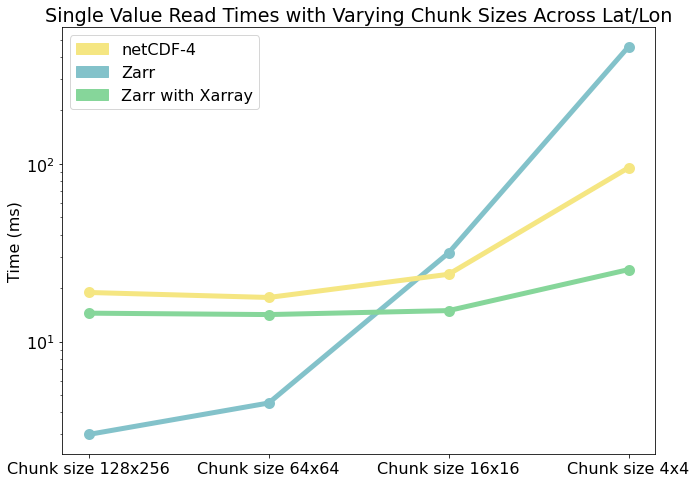

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

netcdf_110 = [nc4_110_single_values_time *1000, nc4_110_64C_single_values_time*1000, nc4_110_16C_single_values_time*1000, nc4_110_4C_single_values_time*1000]
lables = ('Chunk size 128x256','Chunk size 64x64', 'Chunk size 16x16', 'Chunk size 4x4')

zarr = [zarr_single_values_time *1000,  zarr_64C_single_values_time*1000, zarr_16C_single_values_time*1000, zarr_4C_single_values_time*1000]
zarrlables = ('Chunk size 128x256','Chunk size 64x64', 'Chunk size 16x16', 'Chunk size 4x4')

zarrXr = [zarrXr_single_values_time *1000,  zarrXr_64C_single_values_time*1000, zarrXr_16C_single_values_time*1000, zarrXr_4C_single_values_time*1000]
zarrXrlables = ('Chunk size 128x256','Chunk size 64x64', 'Chunk size 16x16', 'Chunk size 4x4')

# Plotting Options
fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(10)

plt.scatter(zarrlables, zarr, color = '#83C2CA', linewidth = 5)
plt.plot(zarr, color = '#83C2CA', linewidth = 5)

plt.scatter(lables, netcdf_110, color = '#F5E682', linewidth = 5)
plt.plot(netcdf_110, color = '#F5E682', linewidth = 5)

plt.scatter(zarrXrlables, zarrXr, color = '#86D69A', linewidth = 5)
plt.plot(zarrXr, color = '#86D69A', linewidth = 5)

plt.ylabel('Time (ms)')
plt.title('Single Value Read Times with Varying Chunk Sizes Across Lat/Lon')

netcdflabel = mpatches.Patch(color='#F5E682', label='netCDF-4')
zarrlabel = mpatches.Patch(color='#83C2CA', label='Zarr')
zarrXrlabel = mpatches.Patch(color='#86D69A', label='Zarr with Xarray')
plt.legend(handles=[netcdflabel, zarrlabel, zarrXrlabel])

plt.yscale('log')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

plt.savefig('Plots/Chunking_netcdf_zarr_single_val.jpg')

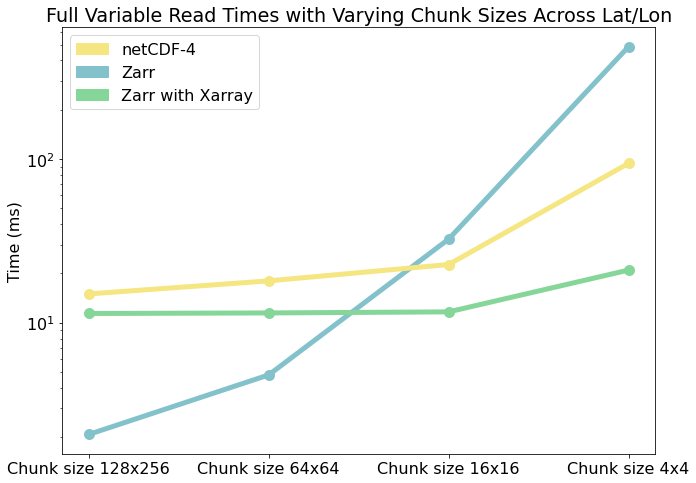

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

netcdf_110 = [nc4_110_full_vars_time *1000, nc4_110_64C_full_vars_time*1000, nc4_110_16C_full_vars_time*1000, nc4_110_4C_full_vars_time*1000]
lables = ('Chunk size 128x256','Chunk size 64x64', 'Chunk size 16x16', 'Chunk size 4x4')

zarr = [zarr_full_vars_time *1000,  zarr_64C_full_vars_time*1000, zarr_16C_full_vars_time*1000, zarr_4C_full_vars_time*1000]
zarrlables = ('Chunk size 128x256','Chunk size 64x64', 'Chunk size 16x16', 'Chunk size 4x4')

zarrXr = [zarrXr_full_vars_time *1000,  zarrXr_64C_full_vars_time*1000, zarrXr_16C_full_vars_time*1000, zarrXr_4C_full_vars_time*1000]
zarrXrlables = ('Chunk size 128x256','Chunk size 64x64', 'Chunk size 16x16', 'Chunk size 4x4')

# Plotting Options
fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(10)

plt.scatter(zarrlables, zarr, color = '#83C2CA', linewidth = 5)
plt.plot(zarr, color = '#83C2CA', linewidth = 5)

plt.scatter(lables, netcdf_110, color = '#F5E682', linewidth = 5)
plt.plot(netcdf_110, color = '#F5E682', linewidth = 5)

plt.scatter(zarrXrlables, zarrXr, color = '#86D69A', linewidth = 5)
plt.plot(zarrXr, color = '#86D69A', linewidth = 5)

plt.ylabel('Time (ms)')
plt.title('Full Variable Read Times with Varying Chunk Sizes Across Lat/Lon')

netcdflabel = mpatches.Patch(color='#F5E682', label='netCDF-4')
zarrlabel = mpatches.Patch(color='#83C2CA', label='Zarr')
zarrXrlabel = mpatches.Patch(color='#86D69A', label='Zarr with Xarray')
plt.legend(handles=[netcdflabel, zarrlabel, zarrXrlabel])

plt.yscale('log')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

plt.savefig('Plots/Chunking_netcdf_zarr_full_var.jpg')